# Policy/Pi-Value/Q-Adverserial/A gradients (PQA)


In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [13]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [14]:
import numpy as np
import gym

## Create the Cart-Pole game environment
# env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


In [15]:
# Data of the model
def model_input(state_size):
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    rewards = tf.placeholder(tf.float32, [None], name='rewards') # env rewards
    rewards2 = tf.placeholder(tf.float32, [None], name='rewards2') # actions logits rewards
    rewards3 = tf.placeholder(tf.float32, [None], name='rewards3') # actions labels rewards
    return states, actions, rewards, rewards2, rewards3

In [16]:
# Generator/Controller: Generating/prediting the actions
def generator(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        # return actions logits
        return logits

In [17]:
# Discriminator/Dopamine: Reward function/planner/naviator/advisor/supervisor/cortical columns
def discriminator(states, actions, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        # Fusion/merge states and actions/ SA/ SM
        x_fused = tf.concat(axis=1, values=[states, actions])
        
        # First fully connected layer
        h1 = tf.layers.dense(inputs=x_fused, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)        
        #predictions = tf.nn.softmax(logits)

        # return rewards logits
        return logits

In [24]:
def model_loss(action_size, hidden_size, # model init
               states, actions, rewards, rewards2, rewards3): # model input for G & D 
    # policy learning/gradient
    actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    g_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=actions_logits, 
                                                                       labels=actions_labels))        
    
    #actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size, reuse=True)
    actions_probs = tf.nn.softmax(actions_logits)
    Qs2_logits = discriminator(actions=actions_probs, hidden_size=hidden_size, states=states) # Q=sum(rewards)
    rewards2_logits = tf.nn.sigmoid(Qs2_logits) # total_rewards2
    #d_loss_fake = tf.reduce_mean(tf.square(Qs2_logits[:-1] - tf.reshape(rewards2[1:], shape=[-1, 1])))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Qs2_logits,
                                                                         labels=tf.reshape(rewards, shape=[-1, 1])))
    d_loss_fake += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Qs2_logits[:-1],
                                                                          labels=tf.reshape(rewards3[1:], 
                                                                                            shape=[-1, 1])))
    
    # Real or env or onehot encoded or label
    #actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    Qs3_logits = discriminator(actions=actions_labels, hidden_size=hidden_size, states=states, reuse=True)
    rewards3_logits = tf.nn.sigmoid(Qs3_logits) # total_rewards3
    #d_loss_real += tf.reduce_mean(tf.square(Qs3_logits[:-1] - tf.reshape(rewards3[1:], shape=[-1, 1])))
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Qs3_logits,
                                                                          labels=tf.reshape(rewards, shape=[-1, 1])))
    d_loss_real += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Qs3_logits[:-1],
                                                                          labels=tf.reshape(rewards3[1:], 
                                                                                            shape=[-1, 1])))
    d_loss_real += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Qs2_logits,
                                                                          labels=tf.zeros_like(tf.reshape(
                                                                              rewards, shape=[-1, 1]))))
    d_loss_real += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Qs2_logits[:-1],
                                                                          labels=tf.zeros_like(
                                                                              tf.reshape(rewards3[1:], shape=[-1, 1]))))
    
    # Returning/outputing actions, sum of rewards, rewards, and loss
    return actions_logits, rewards2_logits, rewards3_logits, g_loss, d_loss_fake, d_loss_real

In [25]:
# Optimizating/training/learning G & D
def model_opt(g_loss, d_loss_fake, d_loss_real, learning_rate):
    """
    Get optimization operations in order
    :param g_loss: Generator loss Tensor for action prediction
    :param d_loss_fake: Discriminator loss Tensor for reward prediction for generated/prob/logits action
    :param d_loss_real: Discriminator loss Tensor for reward prediction for env/onehot/labels action
    :param learning_rate: Learning Rate Placeholder
    :return: A tuple of (qfunction training, generator training, discriminator training)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        g_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars)
        d_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss_real, var_list=d_vars)
        gd_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss_fake, var_list=g_vars)

    return g_opt, d_opt, gd_opt

In [26]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.rewards, self.rewards2, self.rewards3 = model_input(state_size=state_size)
        
        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.rewards2_logits, self.rewards3_logits, self.g_loss, self.d_loss_fake, self.d_loss_real = model_loss(
            action_size=action_size, hidden_size=hidden_size, # model init 
            actions=self.actions, states=self.states, # model input
            rewards=self.rewards, rewards2=self.rewards2, rewards3=self.rewards3) # model input
        
        # Update the model: backward pass and backprop
        self.g_opt, self.d_opt, self.gd_opt = model_opt(g_loss=self.g_loss, 
                                                        d_loss_fake=self.d_loss_fake,
                                                        d_loss_real=self.d_loss_real,
                                                        learning_rate=learning_rate)

In [30]:
# Training parameters
train_episodes = 1000          # max number of episodes to learn from
max_steps = 300000000          # max steps in an episode
learning_rate = 0.001          # learning rate for adam

# Network parameters
state_size = 4                 # number of units for the input state/observation -- simulation
action_size = 2                # number of units for the output actions -- simulation
hidden_size = 64               # number of units in each Q-network hidden layer -- simulation

In [31]:
# Reset/init the graph/session
tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, hidden_size=hidden_size, state_size=state_size, learning_rate=learning_rate)

In [34]:
# Now train with experiences
saver = tf.train.Saver()
# t_vars = tf.trainable_variables()
# g_vars = [var for var in t_vars if var.name.startswith('generator')]
# d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
# saver = tf.train.Saver(var_list=d_vars)
# saver = tf.train.Saver(var_list=g_vars) # train D
# saver = tf.train.Saver(var_list=t_vars)

# Env reward, action logits reward, action labels/onehot reward
rewards_list, rewards2_list, rewards3_list, g_loss_list, d_loss_fake_list, d_loss_real_list = [], [], [], [], [], []

# TF session for training
with tf.Session() as sess:
    
    # Rstoring/loading the trained/learned controller SA/SM
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, 'checkpoints/model-g.ckpt') 
    #saver.restore(sess, 'checkpoints/model-g-d.ckpt') 
    #saver.save(sess, 'checkpoints/model-g-d2.ckpt')
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Training episodes/epochs
    for ep in range(train_episodes):
        state = env.reset() # env first state
        batch = [] # every data batch
        total_reward = 0 # reward env
        total_reward2 = 0 # reward action logits
        total_reward3 = 0 # reward action onehot/labels

        # Training steps/batches
        for _ in range(max_steps): # start=0, step=1, stop=max_steps/done/reward
            action_logits = sess.run([model.actions_logits], feed_dict={model.states: np.reshape(state, [1, -1])})
            action = np.argmax(action_logits)
            next_state, reward, done, _ = env.step(action)
            #action *= 1-float(done)
            reward2, reward3 = sess.run([model.rewards2_logits, model.rewards3_logits],
                                        feed_dict={model.states: np.reshape(state, [1, -1]), 
                                                   model.actions: np.array([action])})
            total_reward += reward # env
            total_reward2 += reward2[0, 0] #_action_logits
            total_reward3 += reward3[0, 0] #_actions_labels
            # state & action pair for policy learning: current policy/action
            # reward for adverserial/reward learning: current reward/value
            # reward2 and reward3 for value/Q learning: future rewards/value
            batch.append([state, action, reward, reward2[0, 0], reward3[0, 0]])
            state = next_state
            if done is True:
                break
                
        #batch = memory.buffer
        states = np.array([each[0] for each in batch])
        actions = np.array([each[1] for each in batch])
        rewards = np.array([each[2] for each in batch])
        rewards2 = np.array([each[3] for each in batch])
        rewards3 = np.array([each[4] for each in batch])
#         g_loss, _ = sess.run([model.g_loss, model.g_opt], feed_dict = {model.states: states,
#                                                                        model.actions: actions})
#         d_loss_fake, _ = sess.run([model.d_loss_fake, model.gd_opt], 
#                              feed_dict = {model.states: states,
#                                           model.actions: actions, 
#                                           model.rewards:rewards, 
#                                           model.rewards2:rewards2, 
#                                           model.rewards3:rewards3})
#         d_loss_real, _ = sess.run([model.d_loss_real, model.d_opt], 
#                                      feed_dict = {model.states: states,
#                                                   model.actions: actions, 
#                                                   model.rewards:rewards, 
#                                                   model.rewards2:rewards2, 
#                                                   model.rewards3:rewards3})
        g_loss, d_loss_fake, d_loss_real, _, _ = sess.run([model.g_loss, model.d_loss_fake, model.d_loss_real,
                                                           model.g_opt, model.d_opt], 
                                                          feed_dict = {model.states: states, 
                                                                       model.actions: actions, 
                                                                       model.rewards:rewards, 
                                                                       model.rewards2:rewards2,
                                                                       model.rewards3:rewards3})
        print('Episode: {}'.format(ep),
              'total_reward: {}'.format(total_reward),
              'total_reward2: {:.4f}'.format(total_reward2),
              'total_reward3: {:.4f}'.format(total_reward3),
              'g_loss: {:.4f}'.format(g_loss),
              'd_loss_fake: {:.4f}'.format(d_loss_fake),
              'd_loss_real: {:.4f}'.format(d_loss_real))
        rewards_list.append([ep, total_reward])
        rewards2_list.append([ep, total_reward2])
        rewards3_list.append([ep, total_reward3])
        g_loss_list.append([ep, g_loss])
        d_loss_fake_list.append([ep, d_loss_fake])
        d_loss_real_list.append([ep, d_loss_real])
        
    # Save the trained/learned D using G/SM/SA
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model-g-d2.ckpt')
    #saver.save(sess, tf.train.latest_checkpoint('checkpoints'))

INFO:tensorflow:Restoring parameters from checkpoints/model-g.ckpt
Episode: 0 total_reward: 500.0 total_reward2: 235.8239 total_reward3: 237.4873 g_loss: 0.1825 d_loss_fake: 1.4435 d_loss_real: 2.7125
Episode: 1 total_reward: 190.0 total_reward2: 88.5689 total_reward3: 88.7527 g_loss: 0.1135 d_loss_fake: 1.4543 d_loss_real: 2.7075
Episode: 2 total_reward: 88.0 total_reward2: 40.1298 total_reward3: 40.1701 g_loss: 0.0302 d_loss_fake: 1.4748 d_loss_real: 2.6918
Episode: 3 total_reward: 500.0 total_reward2: 219.4705 total_reward3: 220.5822 g_loss: 0.1800 d_loss_fake: 1.5097 d_loss_real: 2.6605
Episode: 4 total_reward: 500.0 total_reward2: 212.6554 total_reward3: 214.2475 g_loss: 0.1852 d_loss_fake: 1.5381 d_loss_real: 2.6386
Episode: 5 total_reward: 500.0 total_reward2: 208.6197 total_reward3: 209.5698 g_loss: 0.1814 d_loss_fake: 1.5544 d_loss_real: 2.6302
Episode: 6 total_reward: 464.0 total_reward2: 182.8743 total_reward3: 182.8115 g_loss: 0.1096 d_loss_fake: 1.6031 d_loss_real: 2.6065


Episode: 62 total_reward: 500.0 total_reward2: 159.0620 total_reward3: 174.7701 g_loss: 0.1589 d_loss_fake: 1.8010 d_loss_real: 2.4683
Episode: 63 total_reward: 500.0 total_reward2: 169.1101 total_reward3: 186.7383 g_loss: 0.1423 d_loss_fake: 1.7619 d_loss_real: 2.4838
Episode: 64 total_reward: 500.0 total_reward2: 161.5433 total_reward3: 187.7666 g_loss: 0.1555 d_loss_fake: 1.8152 d_loss_real: 2.4321
Episode: 65 total_reward: 500.0 total_reward2: 158.6827 total_reward3: 184.8548 g_loss: 0.1482 d_loss_fake: 1.8277 d_loss_real: 2.4261
Episode: 66 total_reward: 177.0 total_reward2: 66.2404 total_reward3: 67.0440 g_loss: 0.0183 d_loss_fake: 1.6502 d_loss_real: 2.5745
Episode: 67 total_reward: 500.0 total_reward2: 155.5252 total_reward3: 182.3142 g_loss: 0.1507 d_loss_fake: 1.8482 d_loss_real: 2.4194
Episode: 68 total_reward: 500.0 total_reward2: 154.2775 total_reward3: 182.0031 g_loss: 0.1541 d_loss_fake: 1.8583 d_loss_real: 2.4140
Episode: 69 total_reward: 500.0 total_reward2: 154.7429 t

Episode: 123 total_reward: 500.0 total_reward2: 146.0239 total_reward3: 208.8115 g_loss: 0.1265 d_loss_fake: 2.1611 d_loss_real: 2.2977
Episode: 124 total_reward: 500.0 total_reward2: 144.5790 total_reward3: 205.8359 g_loss: 0.1274 d_loss_fake: 2.1241 d_loss_real: 2.3006
Episode: 125 total_reward: 500.0 total_reward2: 146.9604 total_reward3: 201.7246 g_loss: 0.1343 d_loss_fake: 2.0460 d_loss_real: 2.3202
Episode: 126 total_reward: 500.0 total_reward2: 149.5478 total_reward3: 212.9683 g_loss: 0.1182 d_loss_fake: 2.1431 d_loss_real: 2.3050
Episode: 127 total_reward: 500.0 total_reward2: 147.8330 total_reward3: 214.4777 g_loss: 0.1262 d_loss_fake: 2.1932 d_loss_real: 2.2937
Episode: 128 total_reward: 500.0 total_reward2: 147.2461 total_reward3: 213.9297 g_loss: 0.1263 d_loss_fake: 2.2055 d_loss_real: 2.2900
Episode: 129 total_reward: 500.0 total_reward2: 141.6039 total_reward3: 214.4641 g_loss: 0.1315 d_loss_fake: 2.2445 d_loss_real: 2.2577
Episode: 130 total_reward: 500.0 total_reward2: 

Episode: 184 total_reward: 500.0 total_reward2: 128.4519 total_reward3: 205.1666 g_loss: 0.1080 d_loss_fake: 2.6342 d_loss_real: 2.2349
Episode: 185 total_reward: 500.0 total_reward2: 136.0285 total_reward3: 214.0346 g_loss: 0.1114 d_loss_fake: 2.5453 d_loss_real: 2.2390
Episode: 186 total_reward: 500.0 total_reward2: 144.2995 total_reward3: 231.2844 g_loss: 0.1080 d_loss_fake: 2.7829 d_loss_real: 2.2318
Episode: 187 total_reward: 500.0 total_reward2: 151.1097 total_reward3: 234.8953 g_loss: 0.1006 d_loss_fake: 2.6972 d_loss_real: 2.2566
Episode: 188 total_reward: 500.0 total_reward2: 144.0420 total_reward3: 228.1828 g_loss: 0.1158 d_loss_fake: 2.8816 d_loss_real: 2.2463
Episode: 189 total_reward: 500.0 total_reward2: 141.6017 total_reward3: 226.3640 g_loss: 0.1125 d_loss_fake: 2.8716 d_loss_real: 2.2404
Episode: 190 total_reward: 500.0 total_reward2: 136.9439 total_reward3: 211.5558 g_loss: 0.0982 d_loss_fake: 2.7793 d_loss_real: 2.2632
Episode: 191 total_reward: 500.0 total_reward2: 

Episode: 245 total_reward: 500.0 total_reward2: 139.8135 total_reward3: 221.4972 g_loss: 0.0925 d_loss_fake: 3.1327 d_loss_real: 2.2452
Episode: 246 total_reward: 500.0 total_reward2: 133.4966 total_reward3: 215.0215 g_loss: 0.0944 d_loss_fake: 3.2013 d_loss_real: 2.2335
Episode: 247 total_reward: 500.0 total_reward2: 127.9949 total_reward3: 203.4131 g_loss: 0.0994 d_loss_fake: 2.9207 d_loss_real: 2.2438
Episode: 248 total_reward: 500.0 total_reward2: 141.5128 total_reward3: 219.7075 g_loss: 0.1022 d_loss_fake: 3.3309 d_loss_real: 2.2652
Episode: 249 total_reward: 500.0 total_reward2: 147.3672 total_reward3: 227.0442 g_loss: 0.0991 d_loss_fake: 3.2426 d_loss_real: 2.2707
Episode: 250 total_reward: 500.0 total_reward2: 135.5834 total_reward3: 214.5436 g_loss: 0.0992 d_loss_fake: 2.9526 d_loss_real: 2.2432
Episode: 251 total_reward: 500.0 total_reward2: 143.7193 total_reward3: 230.1995 g_loss: 0.0967 d_loss_fake: 3.2496 d_loss_real: 2.2359
Episode: 252 total_reward: 500.0 total_reward2: 

Episode: 306 total_reward: 500.0 total_reward2: 174.6850 total_reward3: 261.7052 g_loss: 0.0892 d_loss_fake: 3.2182 d_loss_real: 2.3147
Episode: 307 total_reward: 500.0 total_reward2: 180.3875 total_reward3: 261.2253 g_loss: 0.0753 d_loss_fake: 2.7052 d_loss_real: 2.3509
Episode: 308 total_reward: 500.0 total_reward2: 128.6088 total_reward3: 197.5858 g_loss: 0.0836 d_loss_fake: 3.3843 d_loss_real: 2.2687
Episode: 309 total_reward: 500.0 total_reward2: 114.2367 total_reward3: 178.2050 g_loss: 0.0795 d_loss_fake: 3.3346 d_loss_real: 2.2688
Episode: 310 total_reward: 500.0 total_reward2: 95.3155 total_reward3: 156.6664 g_loss: 0.0837 d_loss_fake: 3.5102 d_loss_real: 2.2735
Episode: 311 total_reward: 500.0 total_reward2: 123.1028 total_reward3: 196.3690 g_loss: 0.0867 d_loss_fake: 3.2176 d_loss_real: 2.2487
Episode: 312 total_reward: 500.0 total_reward2: 134.8014 total_reward3: 214.1438 g_loss: 0.0845 d_loss_fake: 3.2547 d_loss_real: 2.2505
Episode: 313 total_reward: 500.0 total_reward2: 1

Episode: 367 total_reward: 500.0 total_reward2: 144.7436 total_reward3: 222.1907 g_loss: 0.0792 d_loss_fake: 3.3440 d_loss_real: 2.2762
Episode: 368 total_reward: 500.0 total_reward2: 144.8055 total_reward3: 209.5405 g_loss: 0.0694 d_loss_fake: 3.1721 d_loss_real: 2.3049
Episode: 369 total_reward: 500.0 total_reward2: 137.8699 total_reward3: 202.8256 g_loss: 0.0732 d_loss_fake: 3.2494 d_loss_real: 2.2906
Episode: 370 total_reward: 500.0 total_reward2: 139.3935 total_reward3: 201.8547 g_loss: 0.0865 d_loss_fake: 3.6724 d_loss_real: 2.3083
Episode: 371 total_reward: 500.0 total_reward2: 141.5441 total_reward3: 205.9691 g_loss: 0.0741 d_loss_fake: 3.3509 d_loss_real: 2.3003
Episode: 372 total_reward: 500.0 total_reward2: 151.3345 total_reward3: 207.4775 g_loss: 0.0639 d_loss_fake: 3.0749 d_loss_real: 2.3456
Episode: 373 total_reward: 500.0 total_reward2: 147.5309 total_reward3: 220.8022 g_loss: 0.0817 d_loss_fake: 3.3410 d_loss_real: 2.2936
Episode: 374 total_reward: 500.0 total_reward2: 

Episode: 428 total_reward: 500.0 total_reward2: 148.8337 total_reward3: 216.2804 g_loss: 0.0700 d_loss_fake: 2.9808 d_loss_real: 2.3085
Episode: 429 total_reward: 500.0 total_reward2: 145.3276 total_reward3: 210.7311 g_loss: 0.0703 d_loss_fake: 3.3973 d_loss_real: 2.3035
Episode: 430 total_reward: 500.0 total_reward2: 144.0271 total_reward3: 207.1978 g_loss: 0.0662 d_loss_fake: 3.2904 d_loss_real: 2.3066
Episode: 431 total_reward: 500.0 total_reward2: 141.2081 total_reward3: 204.2182 g_loss: 0.0663 d_loss_fake: 3.3647 d_loss_real: 2.3009
Episode: 432 total_reward: 500.0 total_reward2: 142.5672 total_reward3: 204.7238 g_loss: 0.0720 d_loss_fake: 3.4561 d_loss_real: 2.3077
Episode: 433 total_reward: 500.0 total_reward2: 143.2582 total_reward3: 205.7485 g_loss: 0.0636 d_loss_fake: 3.0179 d_loss_real: 2.3105
Episode: 434 total_reward: 500.0 total_reward2: 147.6907 total_reward3: 209.4228 g_loss: 0.0762 d_loss_fake: 3.4770 d_loss_real: 2.3252
Episode: 435 total_reward: 500.0 total_reward2: 

Episode: 489 total_reward: 500.0 total_reward2: 152.3695 total_reward3: 209.4955 g_loss: 0.0642 d_loss_fake: 3.4453 d_loss_real: 2.3571
Episode: 490 total_reward: 500.0 total_reward2: 150.4962 total_reward3: 216.4683 g_loss: 0.0615 d_loss_fake: 3.2482 d_loss_real: 2.3219
Episode: 491 total_reward: 500.0 total_reward2: 143.2435 total_reward3: 201.8075 g_loss: 0.0593 d_loss_fake: 3.2070 d_loss_real: 2.3242
Episode: 492 total_reward: 500.0 total_reward2: 138.9472 total_reward3: 190.7463 g_loss: 0.0662 d_loss_fake: 3.5489 d_loss_real: 2.3389
Episode: 493 total_reward: 500.0 total_reward2: 141.9833 total_reward3: 201.9949 g_loss: 0.0605 d_loss_fake: 3.2957 d_loss_real: 2.3231
Episode: 494 total_reward: 500.0 total_reward2: 138.7276 total_reward3: 196.1308 g_loss: 0.0674 d_loss_fake: 3.5312 d_loss_real: 2.3215
Episode: 495 total_reward: 500.0 total_reward2: 147.7115 total_reward3: 205.1978 g_loss: 0.0679 d_loss_fake: 3.4603 d_loss_real: 2.3396
Episode: 496 total_reward: 500.0 total_reward2: 

Episode: 550 total_reward: 500.0 total_reward2: 147.8111 total_reward3: 203.2655 g_loss: 0.0608 d_loss_fake: 3.3917 d_loss_real: 2.3370
Episode: 551 total_reward: 500.0 total_reward2: 146.8617 total_reward3: 200.4866 g_loss: 0.0537 d_loss_fake: 3.2060 d_loss_real: 2.3374
Episode: 552 total_reward: 500.0 total_reward2: 158.8992 total_reward3: 220.8515 g_loss: 0.0674 d_loss_fake: 3.4277 d_loss_real: 2.3516
Episode: 553 total_reward: 500.0 total_reward2: 136.3994 total_reward3: 189.4451 g_loss: 0.0575 d_loss_fake: 3.3572 d_loss_real: 2.3230
Episode: 554 total_reward: 500.0 total_reward2: 135.3342 total_reward3: 186.4780 g_loss: 0.0513 d_loss_fake: 3.2948 d_loss_real: 2.3301
Episode: 555 total_reward: 500.0 total_reward2: 129.3831 total_reward3: 182.7850 g_loss: 0.0609 d_loss_fake: 3.3249 d_loss_real: 2.3236
Episode: 556 total_reward: 500.0 total_reward2: 170.0450 total_reward3: 237.8006 g_loss: 0.0616 d_loss_fake: 3.2970 d_loss_real: 2.3635
Episode: 557 total_reward: 500.0 total_reward2: 

Episode: 611 total_reward: 500.0 total_reward2: 155.5879 total_reward3: 211.8475 g_loss: 0.0559 d_loss_fake: 3.1532 d_loss_real: 2.3605
Episode: 612 total_reward: 500.0 total_reward2: 132.7036 total_reward3: 185.8905 g_loss: 0.0533 d_loss_fake: 3.3172 d_loss_real: 2.3392
Episode: 613 total_reward: 500.0 total_reward2: 137.1398 total_reward3: 184.8640 g_loss: 0.0547 d_loss_fake: 3.3471 d_loss_real: 2.3597
Episode: 614 total_reward: 500.0 total_reward2: 147.4993 total_reward3: 199.5609 g_loss: 0.0545 d_loss_fake: 3.1927 d_loss_real: 2.3616
Episode: 615 total_reward: 500.0 total_reward2: 148.2969 total_reward3: 200.7070 g_loss: 0.0503 d_loss_fake: 3.2036 d_loss_real: 2.3476
Episode: 616 total_reward: 500.0 total_reward2: 159.8217 total_reward3: 209.4235 g_loss: 0.0470 d_loss_fake: 3.1096 d_loss_real: 2.3820
Episode: 617 total_reward: 500.0 total_reward2: 157.5100 total_reward3: 210.6868 g_loss: 0.0565 d_loss_fake: 3.3089 d_loss_real: 2.3705
Episode: 618 total_reward: 500.0 total_reward2: 

Episode: 672 total_reward: 500.0 total_reward2: 152.6600 total_reward3: 201.7023 g_loss: 0.0553 d_loss_fake: 3.2012 d_loss_real: 2.3699
Episode: 673 total_reward: 500.0 total_reward2: 144.9701 total_reward3: 192.0431 g_loss: 0.0519 d_loss_fake: 3.2973 d_loss_real: 2.3555
Episode: 674 total_reward: 500.0 total_reward2: 142.3352 total_reward3: 189.5820 g_loss: 0.0537 d_loss_fake: 3.3945 d_loss_real: 2.3506
Episode: 675 total_reward: 500.0 total_reward2: 144.1456 total_reward3: 193.1913 g_loss: 0.0522 d_loss_fake: 3.2287 d_loss_real: 2.3576
Episode: 676 total_reward: 500.0 total_reward2: 150.2000 total_reward3: 197.1608 g_loss: 0.0507 d_loss_fake: 3.2829 d_loss_real: 2.3676
Episode: 677 total_reward: 500.0 total_reward2: 154.3933 total_reward3: 206.9285 g_loss: 0.0513 d_loss_fake: 3.3180 d_loss_real: 2.3684
Episode: 678 total_reward: 500.0 total_reward2: 153.3024 total_reward3: 205.0677 g_loss: 0.0547 d_loss_fake: 3.3853 d_loss_real: 2.3611
Episode: 679 total_reward: 500.0 total_reward2: 

Episode: 733 total_reward: 500.0 total_reward2: 151.4560 total_reward3: 199.2981 g_loss: 0.0496 d_loss_fake: 3.3467 d_loss_real: 2.3683
Episode: 734 total_reward: 500.0 total_reward2: 149.5049 total_reward3: 196.8549 g_loss: 0.0517 d_loss_fake: 3.4477 d_loss_real: 2.3641
Episode: 735 total_reward: 500.0 total_reward2: 151.0614 total_reward3: 195.2315 g_loss: 0.0503 d_loss_fake: 3.4041 d_loss_real: 2.3829
Episode: 736 total_reward: 500.0 total_reward2: 150.4503 total_reward3: 197.2843 g_loss: 0.0474 d_loss_fake: 3.2525 d_loss_real: 2.3671
Episode: 737 total_reward: 500.0 total_reward2: 148.4743 total_reward3: 196.7959 g_loss: 0.0524 d_loss_fake: 3.4175 d_loss_real: 2.3591
Episode: 738 total_reward: 500.0 total_reward2: 154.0960 total_reward3: 201.8984 g_loss: 0.0475 d_loss_fake: 3.3438 d_loss_real: 2.3834
Episode: 739 total_reward: 500.0 total_reward2: 149.1850 total_reward3: 198.9311 g_loss: 0.0540 d_loss_fake: 3.4844 d_loss_real: 2.3582
Episode: 740 total_reward: 500.0 total_reward2: 

Episode: 794 total_reward: 500.0 total_reward2: 153.5455 total_reward3: 201.3657 g_loss: 0.0489 d_loss_fake: 3.2922 d_loss_real: 2.3720
Episode: 795 total_reward: 500.0 total_reward2: 155.0362 total_reward3: 200.2865 g_loss: 0.0472 d_loss_fake: 3.3140 d_loss_real: 2.3835
Episode: 796 total_reward: 500.0 total_reward2: 159.4834 total_reward3: 204.7120 g_loss: 0.0461 d_loss_fake: 3.0267 d_loss_real: 2.4007
Episode: 797 total_reward: 500.0 total_reward2: 150.1707 total_reward3: 191.4131 g_loss: 0.0411 d_loss_fake: 3.1955 d_loss_real: 2.3867
Episode: 798 total_reward: 500.0 total_reward2: 138.7570 total_reward3: 187.1445 g_loss: 0.0612 d_loss_fake: 3.7023 d_loss_real: 2.3426
Episode: 799 total_reward: 500.0 total_reward2: 143.3752 total_reward3: 190.6721 g_loss: 0.0532 d_loss_fake: 3.5381 d_loss_real: 2.3552
Episode: 800 total_reward: 500.0 total_reward2: 150.5754 total_reward3: 197.8398 g_loss: 0.0516 d_loss_fake: 3.4883 d_loss_real: 2.3684
Episode: 801 total_reward: 500.0 total_reward2: 

Episode: 855 total_reward: 500.0 total_reward2: 148.2586 total_reward3: 193.9934 g_loss: 0.0494 d_loss_fake: 3.4880 d_loss_real: 2.3658
Episode: 856 total_reward: 500.0 total_reward2: 148.9652 total_reward3: 196.3316 g_loss: 0.0549 d_loss_fake: 3.5824 d_loss_real: 2.3659
Episode: 857 total_reward: 500.0 total_reward2: 158.9402 total_reward3: 200.1136 g_loss: 0.0427 d_loss_fake: 3.1772 d_loss_real: 2.4101
Episode: 858 total_reward: 500.0 total_reward2: 154.6379 total_reward3: 200.6527 g_loss: 0.0453 d_loss_fake: 3.3469 d_loss_real: 2.3807
Episode: 859 total_reward: 500.0 total_reward2: 157.3478 total_reward3: 202.5213 g_loss: 0.0439 d_loss_fake: 3.1770 d_loss_real: 2.3961
Episode: 860 total_reward: 500.0 total_reward2: 152.8578 total_reward3: 192.4854 g_loss: 0.0402 d_loss_fake: 3.1136 d_loss_real: 2.3940
Episode: 861 total_reward: 500.0 total_reward2: 151.8636 total_reward3: 187.5503 g_loss: 0.0348 d_loss_fake: 2.9168 d_loss_real: 2.4068
Episode: 862 total_reward: 500.0 total_reward2: 

Episode: 916 total_reward: 500.0 total_reward2: 122.7486 total_reward3: 152.7624 g_loss: 0.0370 d_loss_fake: 3.0763 d_loss_real: 2.4032
Episode: 917 total_reward: 500.0 total_reward2: 153.0570 total_reward3: 197.1297 g_loss: 0.0468 d_loss_fake: 3.4001 d_loss_real: 2.3820
Episode: 918 total_reward: 500.0 total_reward2: 161.3313 total_reward3: 201.5432 g_loss: 0.0390 d_loss_fake: 3.1224 d_loss_real: 2.4112
Episode: 919 total_reward: 500.0 total_reward2: 173.0343 total_reward3: 217.0302 g_loss: 0.0431 d_loss_fake: 3.1390 d_loss_real: 2.4242
Episode: 920 total_reward: 500.0 total_reward2: 167.3802 total_reward3: 212.0759 g_loss: 0.0417 d_loss_fake: 3.1916 d_loss_real: 2.4157
Episode: 921 total_reward: 500.0 total_reward2: 150.1371 total_reward3: 197.9779 g_loss: 0.0480 d_loss_fake: 3.5473 d_loss_real: 2.3688
Episode: 922 total_reward: 500.0 total_reward2: 146.3207 total_reward3: 182.7063 g_loss: 0.0384 d_loss_fake: 3.1032 d_loss_real: 2.3975
Episode: 923 total_reward: 500.0 total_reward2: 

Episode: 977 total_reward: 500.0 total_reward2: 155.9006 total_reward3: 193.4287 g_loss: 0.0370 d_loss_fake: 3.1013 d_loss_real: 2.4046
Episode: 978 total_reward: 500.0 total_reward2: 156.7602 total_reward3: 196.4422 g_loss: 0.0360 d_loss_fake: 3.0218 d_loss_real: 2.4149
Episode: 979 total_reward: 500.0 total_reward2: 141.2380 total_reward3: 180.7167 g_loss: 0.0394 d_loss_fake: 3.2741 d_loss_real: 2.3780
Episode: 980 total_reward: 500.0 total_reward2: 147.7415 total_reward3: 186.9534 g_loss: 0.0386 d_loss_fake: 3.2138 d_loss_real: 2.3919
Episode: 981 total_reward: 500.0 total_reward2: 149.1806 total_reward3: 187.5885 g_loss: 0.0387 d_loss_fake: 3.2097 d_loss_real: 2.3963
Episode: 982 total_reward: 500.0 total_reward2: 158.0666 total_reward3: 196.3797 g_loss: 0.0394 d_loss_fake: 3.2075 d_loss_real: 2.4076
Episode: 983 total_reward: 500.0 total_reward2: 163.5037 total_reward3: 200.9066 g_loss: 0.0377 d_loss_fake: 3.0606 d_loss_real: 2.4231
Episode: 984 total_reward: 500.0 total_reward2: 

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0,0.5,'Total env rewards')

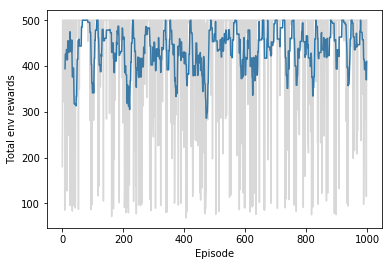

In [24]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total env rewards')

Text(0,0.5,'Total actions logits rewards')

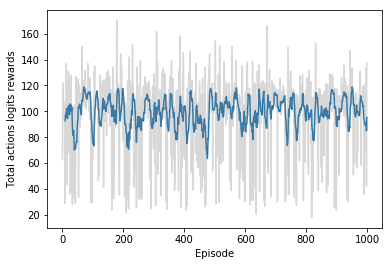

In [25]:
eps, arr = np.array(rewards2_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total actions logits rewards')

Text(0,0.5,'Total actions labels/onehot rewards')

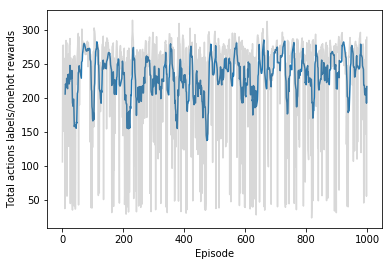

In [26]:
eps, arr = np.array(rewards3_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total actions labels/onehot rewards')

Text(0,0.5,'Gloss')

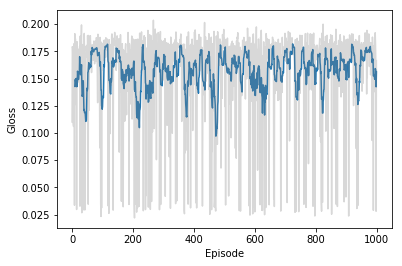

In [27]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Gloss')

Text(0,0.5,'Dloss')

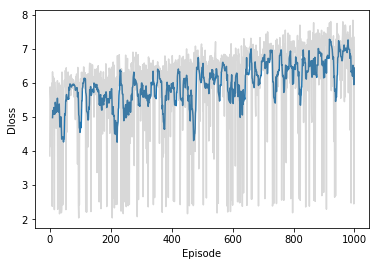

In [28]:
eps, arr = np.array(d_loss_fake_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Dloss')

Text(0,0.5,'Dloss')

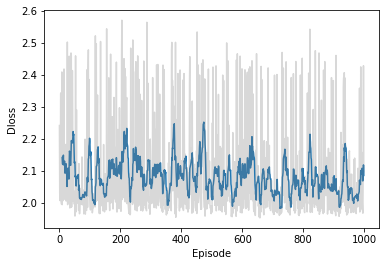

In [29]:
eps, arr = np.array(d_loss_real_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Dloss')